In [21]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE,SVMSMOTE,KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split


In [20]:
cepheid_list = np.load("../dataset/light_curve_instance/cepheid/lc_cepheid.npy",allow_pickle=True)
len(cepheid_list)

KeyboardInterrupt: 

In [ ]:
print(cepheid_list[0].meta)

In [ ]:
from tqdm import tqdm

full_lc_pd = pd.DataFrame(columns = cepheid_list[0].meta.keys())
for lc in tqdm(cepheid_list):
    full_lc_pd = full_lc_pd.append(lc.meta,ignore_index=True)
full_lc_pd

In [5]:
full_lc_pd.to_csv("../dataset/light_curve_dataframe/cepheid/lc_cepheid.csv",index=False)

In [22]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/cepheid/lc_cepheid.csv")

In [23]:
# delete_idx = full_lc_pd[full_lc_pd["peri_optical"].isnull() == True].index
# full_lc_pd = full_lc_pd.drop(delete_idx)

In [24]:
sub_class = full_lc_pd["variable_type"]
features_drop_unlabel = full_lc_pd.drop(labels=["source_id","class_probability","variable_type","created_at","main_type","updated_at","mean_vmag","lksl_statistic","rfr_score","epoch_hjd","e_b_v","vector_x","vector_y","vector_z","periodic","l"], axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)
features_drop_unlabel

,raj2000,dej2000,b,amplitude,period,mean,median,std,skewness,kurtosis,...,phase_eta,peri_optical,pearsonr,Mm_period_ratio,l1,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,310.79987,67.24633,15.02330,0.35,3.926633,12.624732,12.6440,0.119334,-0.293535,-1.243967,...,0.034235,3.215154,0.817310,0.445488,0.958295,-5.687144,8.008793,-1.898098,3.878650,0.436784
1,77.32044,-64.70331,-35.18470,0.36,2.088684,15.190610,15.1960,0.113792,-0.030457,-1.088116,...,0.348689,7.272814,-0.803812,0.369049,0.830162,-0.937212,0.662440,-0.394233,0.340217,0.456209
2,77.32044,-64.70331,-35.18470,0.36,2.088684,15.181465,15.1960,0.112264,-0.094424,-1.134294,...,0.393449,7.268436,-0.782158,0.201067,0.807894,-0.381057,0.363685,-0.140914,0.178288,0.435883
3,294.76155,24.38494,1.20807,0.58,5.171102,14.729574,14.7665,0.195464,-0.056890,-1.411490,...,0.099079,2.848440,0.747205,0.652410,0.942369,-2.501995,3.541191,-0.933468,1.772922,0.510828
4,218.81848,-67.37944,-6.49576,1.05,2.242517,16.050593,16.0630,0.327898,0.106559,-0.945883,...,0.496881,7.157402,0.562861,0.266138,0.792623,-0.268636,0.205061,-0.112563,0.114487,0.292923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,82.31937,-67.47275,-32.73992,0.87,13.420894,14.071352,14.0730,0.251560,-0.314950,-0.855692,...,0.037554,1.048466,0.938600,0.454573,0.974491,-3.270565,3.443486,-1.536690,1.231369,0.382776
4644,273.47423,-64.60680,-20.46853,1.20,1.730097,14.195057,14.2030,0.347610,-0.332813,-0.982250,...,0.127093,8.204774,-0.409689,0.202314,0.940084,-0.363470,0.910712,-0.166356,0.450779,0.483828
4645,81.16232,-66.43103,-33.33331,0.50,8.926746,14.830084,14.8200,0.158128,0.148821,-1.279489,...,0.154566,1.661309,-0.471253,0.682410,0.925440,-5.456310,2.382115,-2.305983,1.216406,0.488884
4646,81.16232,-66.43103,-33.33331,0.50,8.926746,14.840917,14.8200,0.162239,0.208626,-1.330351,...,0.131675,1.662523,-0.860432,0.711840,0.937132,-1.908869,1.647371,-0.872921,0.851560,0.500447


In [25]:
label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

In [27]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.3, shuffle=True,random_state=0)
# X_train, y_train = BorderlineSMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 529), (1, 590), (2, 1412), (3, 573), (4, 149)]


In [28]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = [
    {'n_estimators': (50,100)},
]
clf = GradientBoostingClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START n_estimators=50.............................................
[CV 1/5; 1/2] END n_estimators=50;, score=(train=0.923, test=0.839) total time=   5.9s
[CV 2/5; 1/2] START n_estimators=50.............................................
[CV 2/5; 1/2] END n_estimators=50;, score=(train=0.918, test=0.837) total time=   5.8s
[CV 3/5; 1/2] START n_estimators=50.............................................
[CV 3/5; 1/2] END n_estimators=50;, score=(train=0.918, test=0.839) total time=   6.1s
[CV 4/5; 1/2] START n_estimators=50.............................................
[CV 4/5; 1/2] END n_estimators=50;, score=(train=0.924, test=0.838) total time=   5.8s
[CV 5/5; 1/2] START n_estimators=50.............................................
[CV 5/5; 1/2] END n_estimators=50;, score=(train=0.924, test=0.829) total time=   6.0s
[CV 1/5; 2/2] START n_estimators=100............................................
[CV 1/5; 2/2] END n

In [13]:
grid_search.score(X_test,y_test)

0.8376344086021505

In [14]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8867115737905695 {'n_estimators': 50}
0.9071647274954072 {'n_estimators': 100}


In [15]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, feature_name), reverse=True)

[(0.4019783107324594, 'r21'),
 (0.2595713401527109, 'period'),
 (0.06923990767884003, 'peri_optical'),
 (0.030244905117620482, 'amplitude'),
 (0.02596561557683124, 'raj2000'),
 (0.025236451642174713, 'slope_per20'),
 (0.019507770401994688, 'b'),
 (0.015318373148482714, 'dej2000'),
 (0.014418374454217371, 'phi31'),
 (0.012709714926686832, 'phi21'),
 (0.010234525328216431, 'phase_eta'),
 (0.010115456949057406, 'l1'),
 (0.009889238065807745, 'r31'),
 (0.008750378998707835, 'r52'),
 (0.007030861574131323, 'mean'),
 (0.006286458929130568, 'hl_amp_ratio'),
 (0.005907713121454112, 'r53'),
 (0.005075019409346131, 'r32'),
 (0.005003827630059074, 'skewness'),
 (0.004036337502374766, 'shapiro_w'),
 (0.003865570528929011, 'median'),
 (0.00363192255962207, 'p2p'),
 (0.003556299558031884, 'r43'),
 (0.00348511663081161, 'slope_per10'),
 (0.002770202234807511, 'r41'),
 (0.0025316769984353405, 'slope_per80'),
 (0.002469449124087297, 'f_phase'),
 (0.002458424180311196, 'MAD'),
 (0.002456848326449589, 'r

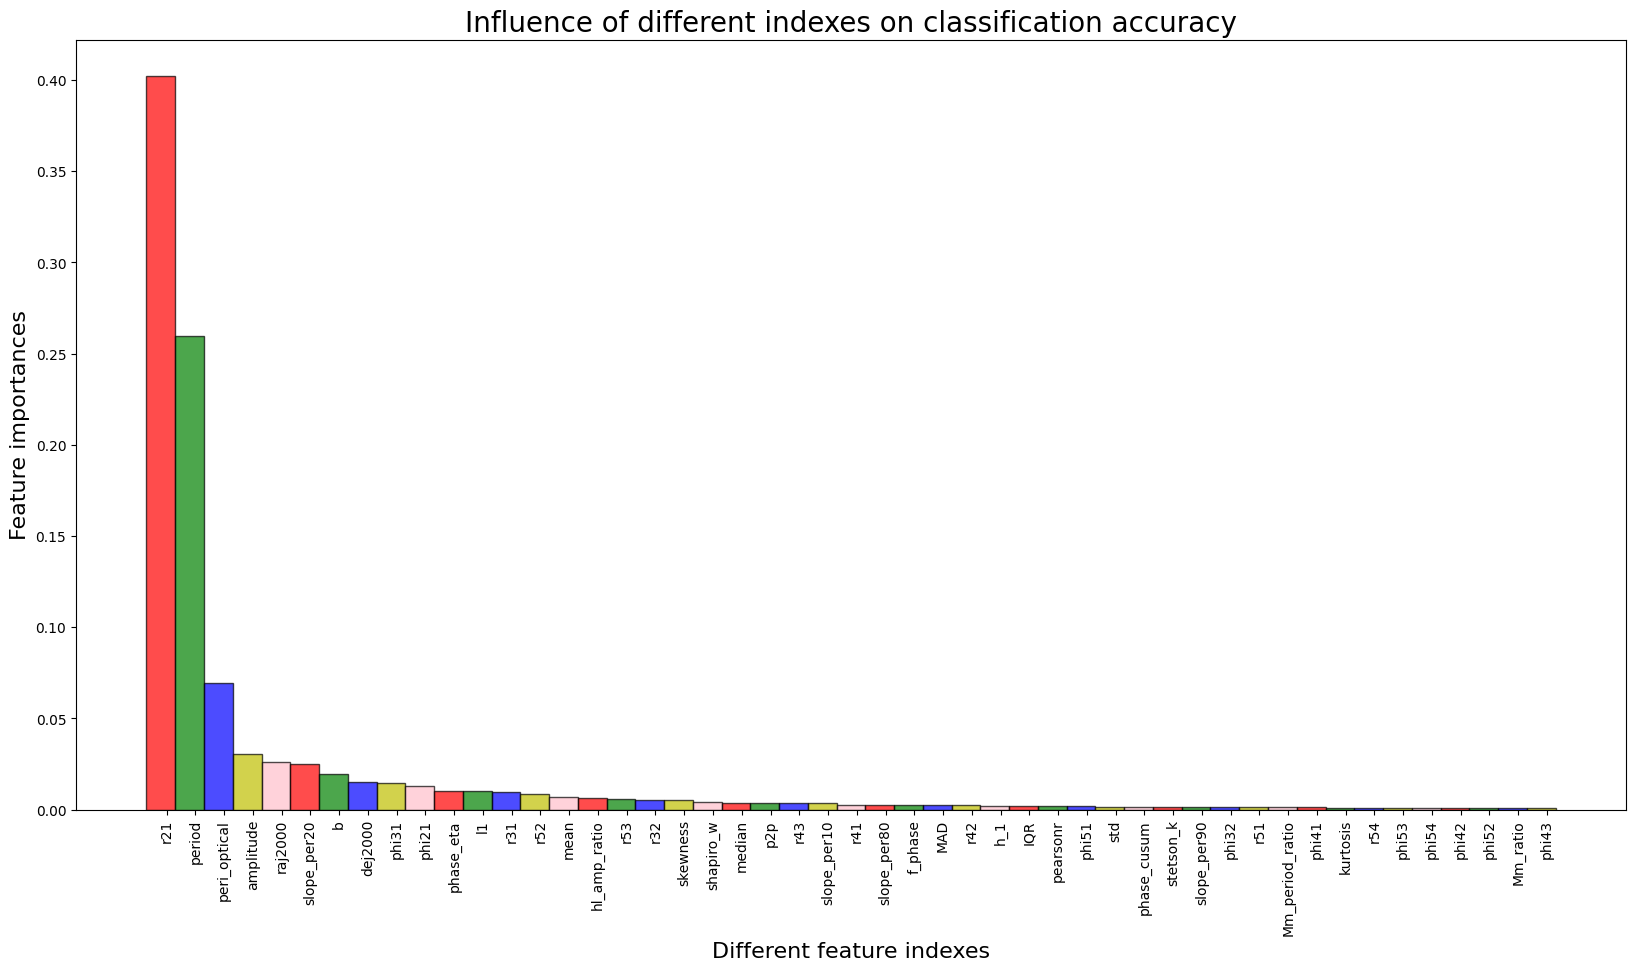

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_important/random_forest_cepheids_importance_0.9071647274954072.png'

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10))
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search.best_score_}.png")

([<matplotlib.axis.YTick at 0x2ee39f53ee0>,
 [Text(0, 0, 'CWA'),
  Text(0, 1, 'CWB'),
  Text(0, 2, 'DCEP'),
  Text(0, 3, 'DCEPS'),
  Text(0, 4, 'RVA')])

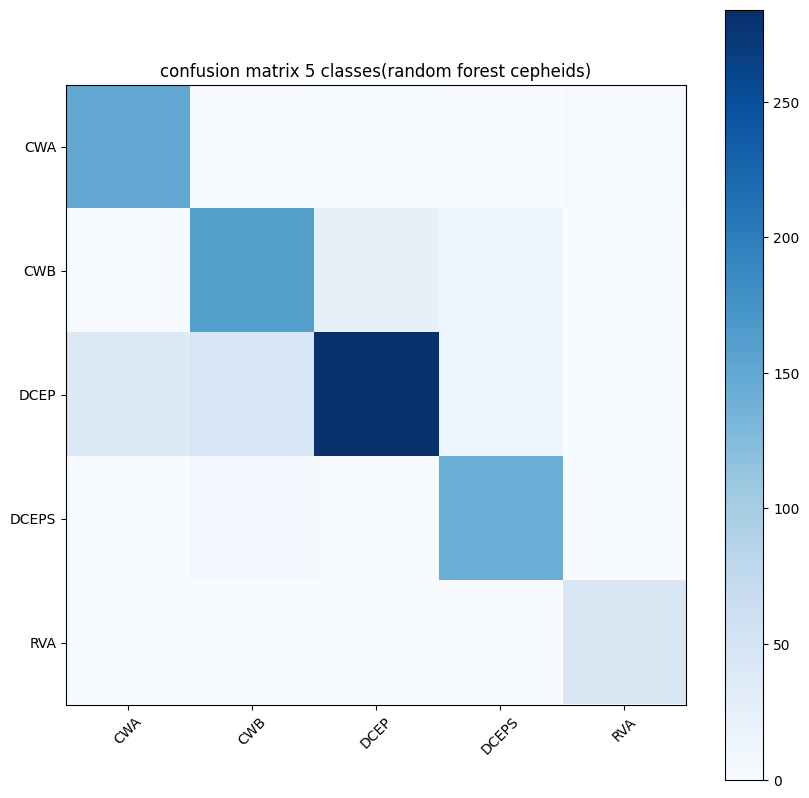

In [17]:
# from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix 5 classes(random forest cepheids)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [18]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=classes))

0.8844990942964503
0.8603441285223743
0.8432653390818571
0.8844990942964503
              precision    recall  f1-score   support

         CWA       0.80      0.96      0.87       156
         CWB       0.75      0.81      0.78       197
        DCEP       0.90      0.75      0.82       379
       DCEPS       0.85      0.93      0.89       154
         RVA       0.91      0.98      0.95        44

    accuracy                           0.84       930
   macro avg       0.84      0.88      0.86       930
weighted avg       0.84      0.84      0.84       930



In [97]:
joblib.dump(label_encoder, f"./output/label_encoder/cepheids_label_{grid_search.best_score_}.pkl")

FileNotFoundError: [Errno 2] No such file or directory: './output/label_encoder/cepheids_label_0.9873653937708639.pkl'

In [37]:
root = os.getcwd().split("train")[0]
features_root = os.path.join(root, "datasets", "new_astronomy_lc_features_v1")
full_lc = np.load(os.path.join(features_root, "cepheids_var.npy"), allow_pickle=True)
full_lc_list = full_lc.tolist()
full_lc_pd = pd.DataFrame(full_lc_list)
full_lc_pd = full_lc_pd[full_lc_pd["class_probability"] >= 0.95]

sub_class = full_lc_pd["type"]
features_drop_unlabel = full_lc_pd[useful_feature_cepheids_new]
features_drop_unlabel = features_drop_unlabel.drop(labels=["class_probability","type"], axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)

label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

np.random.seed(42)
# 0:92204
# 1:9005 2:905913  3:9139  4:90322 5:93817  6:87903
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2,
                                                    shuffle=True,random_state=5)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

param_grid = [
    {'n_estimators': range(10, 31, 5), 'max_features': range(10, 51, 5)},
    {'bootstrap': [False], 'n_estimators': range(10, 31, 5), 'max_features': range(10, 51, 5)}
]
clf = RandomForestClassifier(n_jobs=-1)
grid_search_new = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search_new.fit(X_train, y_train)
print(grid_search_new.best_params_)
print(grid_search_new.best_estimator_)
print(grid_search_new.best_score_)
grid_search_new.score(X_test, y_test)

[(0, 1005), (1, 1005), (2, 1005), (3, 1005), (4, 1005)]
Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 1/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.959) total time=   0.0s
[CV 2/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 2/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.998, test=0.958) total time=   0.0s
[CV 3/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 3/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.977) total time=   0.0s
[CV 4/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 4/5; 1/90] END max_features=10, n_estimators=10;, score=(train=0.999, test=0.972) total time=   0.0s
[CV 5/5; 1/90] START max_features=10, n_estimators=10...........................
[CV 5/5; 1/90] END max_features=10, n_estimators=10;, sco

0.9059139784946236

In [31]:
save_path = os.path.join(root, "model_name/") + f"random_forest_cepheids_{grid_search_new.best_score_}.model"
joblib.dump(grid_search_new, save_path)

['F:\\WorkSpace\\Pycharm\\天文项目\\ASAS-Classification_v5\\model_name/random_forest_cepheids_0.9767164179104476.model']

In [32]:
cvres = grid_search_new.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9669651741293531 {'max_features': 10, 'n_estimators': 10}
0.9741293532338308 {'max_features': 10, 'n_estimators': 15}
0.9751243781094528 {'max_features': 10, 'n_estimators': 20}
0.976318407960199 {'max_features': 10, 'n_estimators': 25}
0.9767164179104476 {'max_features': 10, 'n_estimators': 30}
0.9649751243781095 {'max_features': 15, 'n_estimators': 10}
0.9701492537313433 {'max_features': 15, 'n_estimators': 15}
0.973134328358209 {'max_features': 15, 'n_estimators': 20}
0.9739303482587065 {'max_features': 15, 'n_estimators': 25}
0.9735323383084576 {'max_features': 15, 'n_estimators': 30}
0.9623880597014924 {'max_features': 20, 'n_estimators': 10}
0.9699502487562188 {'max_features': 20, 'n_estimators': 15}
0.9711442786069652 {'max_features': 20, 'n_estimators': 20}
0.9717412935323383 {'max_features': 20, 'n_estimators': 25}
0.9741293532338308 {'max_features': 20, 'n_estimators': 30}
0.9677611940298508 {'max_features': 25, 'n_estimators': 10}
0.9669651741293533 {'max_features': 25, 'n

In [33]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search_new.best_estimator_.feature_importances_
sorted(zip(feature_importances, feature_name), reverse=True)

[(0.12601571120284158, 'ambient_light'),
 (0.11910734953437324, 'r21'),
 (0.0818942847613223, 'period'),
 (0.04726507061073445, 'r31'),
 (0.04632582313057719, 'h_1'),
 (0.040894937760115255, 'slope_per10'),
 (0.030819654009651764, 'eta'),
 (0.028723217311932333, 'r41'),
 (0.026572414912126238, 'phase_cusum'),
 (0.026068662707511306, 'slope_per90'),
 (0.02526140209730426, 'skewness'),
 (0.023784658806753692, 'IQR'),
 (0.022929998846490694, 'MAD'),
 (0.021875709726225014, 'theta_w'),
 (0.021650437674981104, 'variation'),
 (0.02000014955784285, 'amplitude'),
 (0.019235961697496792, 'Mm'),
 (0.019122719728551528, 'l1'),
 (0.018219907422578098, 'hl_amp_ratio'),
 (0.017950306702426835, 'std'),
 (0.014972995347532337, 'r53'),
 (0.01261653044336245, 'r51'),
 (0.009567929932679948, 'RoMS'),
 (0.009012387367914987, 'a2'),
 (0.008442200729528738, 'phase_eta'),
 (0.008305350312270214, 'median'),
 (0.007859240603221334, 'a42'),
 (0.007832562716921497, 'theta_NXS'),
 (0.0076874630055793905, 'mean_vm

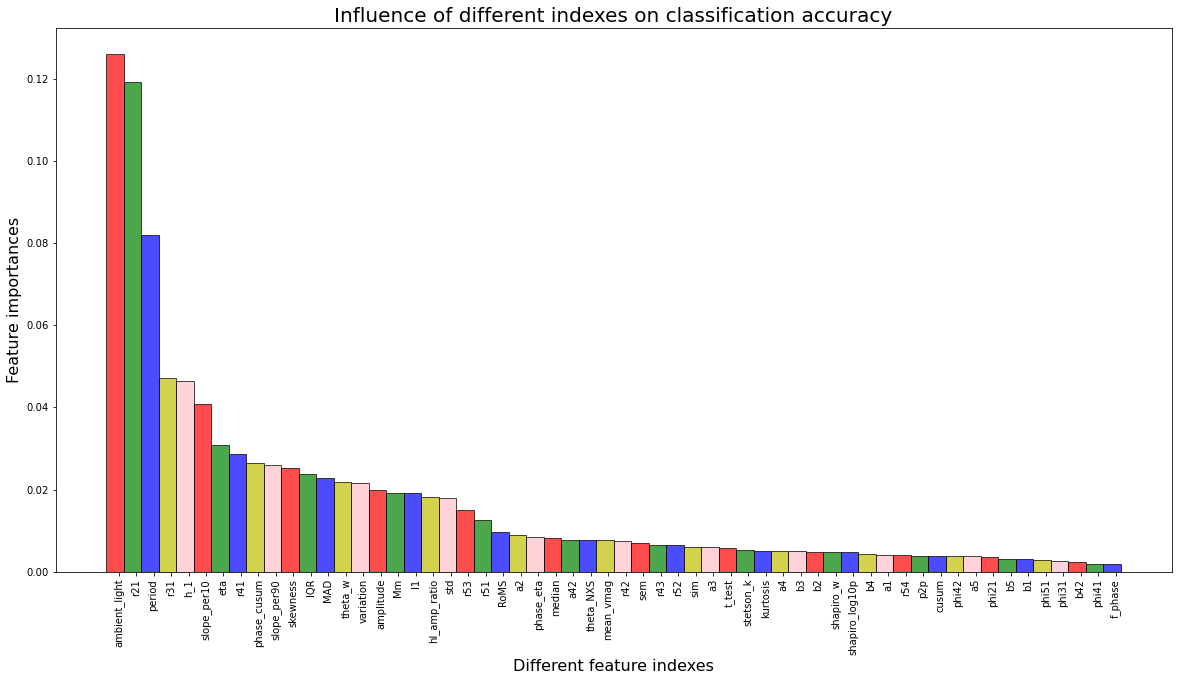

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10))
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search_new.best_score_}.png")

['CWA' 'CWB' 'DCEP' 'DCEPS' 'RVA']


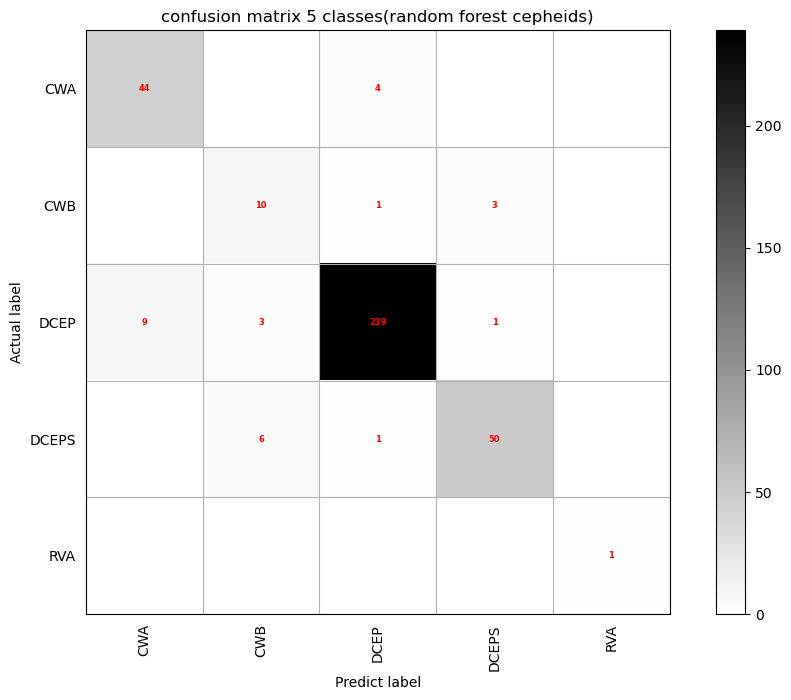

In [35]:
from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search_new.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
print(classes)

save_path = os.path.join(root, "output",
                         "confusion_matrix/") + f"confusion_matrix_random_forest_cepheids_{grid_search_new.best_score_}.png"
plot_confusion_matrix(cm, save_path, classes=classes, title='confusion matrix 5 classes(random forest cepheids)')

In [36]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

print(recall_score(y_test, y_pred, average='weighted'))
print(f1_score(y_test, y_pred, average='weighted'))
print(precision_score(y_test, y_pred, average='weighted'))
print(recall_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred, target_names=classes))

0.9247311827956989
0.9274843526814953
0.9323221152224581
0.9247311827956989
              precision    recall  f1-score   support

         CWA       0.83      0.92      0.87        48
         CWB       0.53      0.71      0.61        14
        DCEP       0.98      0.95      0.96       252
       DCEPS       0.93      0.88      0.90        57
         RVA       1.00      1.00      1.00         1

    accuracy                           0.92       372
   macro avg       0.85      0.89      0.87       372
weighted avg       0.93      0.92      0.93       372

